# CZ gate coherent error benchmarking

In [1]:
import sys
sys.path.append('/Users/tport/miniconda3/envs/basic_scientific/lib/python3.13/site-packages')

# MIT Results

## Wrapper function

In [2]:
import numpy as np
from typing import Any, Callable, Literal
from components import DeviceCharacteristics
from fidelity_optimization import find_best_fit

angle_bound = (-0.1, 0.1); # radians
timescale_bound = (10, 1000); # timescale is in terms of the gate time.
spam_bound = (0, 1);

def init_device_characteristics():
    """Create a new DeviceCharacteristics instance with all elements initialized as
    tuples.
    """
    return DeviceCharacteristics({
            "T1_1": timescale_bound, "T1_2": timescale_bound, "T2_1": timescale_bound, "T2_2": timescale_bound,
            "ZZ": angle_bound, "ZI": angle_bound, "IZ": angle_bound,
            "infinite_time_spam": spam_bound, "zero_time_spam": spam_bound});

def extract_params(
    state : Literal["00", "01", "10", "11", "0+", "+0", "++"], 
    pulse_sequence : Literal["II", "XI", "IX", "XX"], 
    x_data : np.ndarray, 
    y_data : np.ndarray,
    opt : Literal["global", "minimize", "curve", "least_squares"] = "global",
    y_err : np.ndarray | None = None,
    initial_guess : list[Any] | None = None
) -> tuple[dict[str, Any], list[Any], Callable]:
    """
    Args:
        state: initial state of the experiment. Can be one of ["00", "01", "10", "11", "0+", "+0", "++"]
        pulse_sequence: the sequence of X pulses applied. Can be one of ["II", "XI", "IX", "XX"]
        x_data: sequence of number of gates applied. Each element should be an `int` divisible by 4.
        y_data: the series data of fidelity
        opt: the underlying optimization method to use. The default is scipy global optimization (differential evolution)
    """
    device = init_device_characteristics();
    match state:
        case "00":
            device.update_dict({"T1_1": np.inf, "T1_2": np.inf, "T2_1": np.inf, "T2_2": np.inf})
            raise ValueError("Fit function does not yield useful info.")
        case "01":
            device.update_dict({"T1_1": np.inf, "T2_1": np.inf, "T2_2": np.inf})
            raise ValueError("Fit function does not yield useful info.")
        case "10":
            device.update_dict({"T1_2": np.inf, "T2_1": np.inf, "T2_2": np.inf})
            raise ValueError("Fit function does not yield useful info.")
        case "0+":
            device.update_dict({"T1_1": np.inf, "T2_1": np.inf, "T1_2": np.inf})
        case "+0":
            device.update_dict({"T1_1": np.inf, "T1_2": np.inf, "T2_2": np.inf})
        case "++":
            pass
    match pulse_sequence:
        case 'II':
            pass
        case 'XX':
            # DD on first qubit. Only ZZ term remains unaffected.
            device.update_dict({"ZI": -np.pi/4, "IZ": -np.pi/4})
        case 'XI':
            # DD on first qubit. Only IZ term remains unaffected.
            device.update_dict({"ZZ": -np.pi/4, "ZI": -np.pi/4})
        case 'IX':
            # DD on second qubit. Only ZI term remains unaffected.
            device.update_dict({"IZ": -np.pi/4, "ZZ": -np.pi/4})
    
    keys = device.get_optimizee_keys()
    if initial_guess is None:
        initial_guess = []
        for key in keys:
            if key.startswith("T"):
                # Decay timescale params
                initial_guess.append(230)
            elif key.endswith("spam"):
                # SPAM params
                initial_guess.append(1)
            else:
                # Angle params
                initial_guess.append(-0.01)

    exp_literal = state;
    optim_params, _, _, func = find_best_fit(exp_literal, x_data, y_data, device, initial_guess, opt=opt, y_err=y_err)
    result_dict = {keys[i]: optim_params[i] for i in range(len(keys))};
    return result_dict, optim_params, func

## Import Data

The result of i-th experiment (entire circuit, with preparation and unpreparation) as stored as follows:

* `pop_00[i, t]` = P(00 measurement after evolving till t in i-th experiment)
* `pop_01[i, t]` = P(01 measurement after evolving till t in i-th experiment)
* `pop_10[i, t]` = P(10 measurement after evolving till t in i-th experiment)
* `pop_11[i, t]` = P(11 measurement after evolving till t in i-th experiment)
* `pop_qb1[i, t]` = P(1* measurement after evolving till t in i-th experiment)
* `pop_qb2[i, t]` = P(*1 measurement after evolving till t in i-th experiment)

The experiments are numbered as follows (indexing from 0):
* 0th - initial state 00
* 1st - initial state 11
* 2nd - initial state ++, pulse sequence XX
* 3rd - initial state +0, pulse sequence IX
* 4th - initial state 0+, pulse sequence XI
* 5th - initial state +0, pulse sequence XX
* 6th - initial state 0+, pulse sequence XX

In [3]:
import numpy as np

class Exp():
    NO_DD_00 = 0
    NO_DD_11 = 1
    DD_PP_XX = 2
    DD_P0_IX = 3
    DD_0P_XI = 4
    DD_P0_XX = 5
    DD_0P_XX = 6
    
folder = "Deterministic benchmarking result - modified"
n_cz = np.load(f"{folder}/num_cz_gates.npy");
pop_00 = np.load(f"{folder}/pop_00_vs_exp.npy");
pop_01 = np.load(f"{folder}/pop_01_vs_exp.npy");
pop_10 = np.load(f"{folder}/pop_10_vs_exp.npy");
pop_11 = np.load(f"{folder}/pop_11_vs_exp.npy");
pop_qb1 = np.load(f"{folder}/pop_QB1_vs_exp.npy");
pop_qb2 = np.load(f"{folder}/pop_QB2_vs_exp.npy");

sigma_00 = np.sqrt(pop_00 * (1 - pop_00) / 1000);

T1_1 = 50; # microseconds
T1_2 = 25; # microseconds
T2_1 = 40; # microseconds
T2_2 = 4; # microseconds

tg_X = 0.030 + 0.010; # microseconds
tg_cz = 0.070 + 0.010; # microseconds

## Run Analysis

### Compile fits
Gather the fit data for each of the experiments we ran, and print the results.

In [4]:
#############
##  0+ - XI
#############

exp_literal = "0+"
pulse_sequence = "XI"
y_data = pop_00[Exp.DD_0P_XI, :]
y_err = sigma_00[Exp.DD_0P_XI, :]
x_data = n_cz
optim_params_0P_XI, func_params_0P_XI, func_0P_XI = extract_params(exp_literal, pulse_sequence, x_data, y_data, opt = "global")
optim_params_0P_XI, func_params_0P_XI, func_0P_XI = extract_params(
    exp_literal, pulse_sequence, x_data, y_data, opt = "curve", initial_guess=func_params_0P_XI, y_err=y_err)
print(f"From {exp_literal}, {pulse_sequence} experiment: ")
optim_y = func_0P_XI(x_data, *func_params_0P_XI)
print("RMSE Error:", np.sum(np.abs(optim_y - y_data) ** 2))
print(f"Timescale: T2_2 = {optim_params_0P_XI["T2_2"]} * tg")
print(f"Overrotation: IZ = {optim_params_0P_XI["IZ"] * 180/np.pi} degrees")
print(optim_params_0P_XI)
print()

#############
##  0+ - XX
#############

# exp_literal = "0+";
# pulse_sequence = "XX";
# y_data =  pop_00[Exp.DD_0P_XI, :];
# x_data = n_cz;
# optim_params_0P_XX, func_params_0P_XX, func_0P_XX = extract_params(exp_literal, pulse_sequence, x_data, y_data, opt = "global");
# print(f"From {exp_literal}, {pulse_sequence} experiment: ")
# optim_y = func_0P_XX(x_data, *func_params_0P_XX);
# print("RMSE Error:", np.sum(np.abs(optim_y - y_data) ** 2))
# print(f"Timescale: T2_2 = {optim_params_0P_XX["T2_2"]} * tg")
# print(f"Overrotation: ZZ = {optim_params_0P_XX["ZZ"] * 180/np.pi} degrees")
# print()

#############
##  +0 - IX
#############
exp_literal = "+0";
pulse_sequence = "IX";
y_data =  pop_00[Exp.DD_P0_IX, :]
y_err = sigma_00[Exp.DD_P0_IX, :]
x_data = n_cz;
optim_params_P0_IX, func_params_P0_IX, func_P0_IX = extract_params(exp_literal, pulse_sequence, x_data, y_data, opt = "global");
optim_params_P0_IX, func_params_P0_IX, func_P0_IX = extract_params(
    exp_literal, pulse_sequence, x_data, y_data, opt = "curve", initial_guess=func_params_P0_IX, y_err=y_err)
print(f"From {exp_literal}, {pulse_sequence} experiment: ")
optim_y = func_P0_IX(x_data, *func_params_P0_IX);
print("RMSE Error:", np.sum(np.abs(optim_y - y_data) ** 2))
print(f"Timescale: T2_1 = {optim_params_P0_IX["T2_1"]} * tg")
print(f"Overrotation: ZI = {optim_params_P0_IX["ZI"] * 180/np.pi} degrees")
print(optim_params_P0_IX)
print()

#############
##  +0 - IX
#############
# exp_literal = "+0";
# pulse_sequence = "XX";
# y_data =  pop_00[Exp.DD_P0_XX, :];
# x_data = n_cz;
# optim_params_P0_XX, func_params_P0_XX, func_P0_XX = extract_params(exp_literal, pulse_sequence, x_data, y_data, opt = "global");
# print(f"From {exp_literal}, {pulse_sequence} experiment: ")
# optim_y = func_P0_XX(x_data, *func_params_P0_XX);
# print("RMSE Error:", np.sum(np.abs(optim_y - y_data) ** 2))
# print(f"Timescale: T2_1 = {optim_params_P0_XX["T2_1"]} * tg")
# print(f"Overrotation: ZZ = {optim_params_P0_XX["ZZ"] * 180/np.pi} degrees")
# print()

#############
##  ++ - XX
#############
exp_literal = "++";
pulse_sequence = "XX";
y_data =  pop_00[Exp.DD_PP_XX, :];
y_err =  sigma_00[Exp.DD_PP_XX, :];
x_data = n_cz;
optim_params_PP_XX, func_params_PP_XX, func_PP_XX = extract_params(exp_literal, pulse_sequence, x_data, y_data, opt = "global");
optim_params_PP_XX, func_params_PP_XX, func_PP_XX = extract_params(
    exp_literal, pulse_sequence, x_data, y_data, opt = "curve", initial_guess=func_params_PP_XX, y_err=y_err)
print(f"From {exp_literal}, {pulse_sequence} experiment: ")
optim_y = func_PP_XX(x_data, *func_params_PP_XX);
print("RMSE Error:", np.sum(np.abs(optim_y - y_data) ** 2))
print(f"Timescales: T1_1 = {optim_params_PP_XX["T1_1"]} * tg, T1_2 = {optim_params_PP_XX["T1_2"]} * tg, T2_1 = {optim_params_PP_XX["T2_1"]} * tg, T2_2 = {optim_params_PP_XX["T2_2"]} * tg")
print(f"Overrotation: ZZ = {optim_params_PP_XX["ZZ"] * 180/np.pi} degrees")
print(optim_params_PP_XX)
print()

From 0+, XI experiment: 
RMSE Error: 0.02271110060076217
Timescale: T2_2 = 234.4320473605797 * tg
Overrotation: IZ = 0.31353911260640227 degrees
{'T2_2': np.float64(234.4320473605797), 'IZ': np.float64(0.005472289848762979), 'infinite_time_spam': np.float64(0.37855073708596215), 'zero_time_spam': np.float64(0.5677505475768803)}

From +0, IX experiment: 
RMSE Error: 0.01614803760653696
Timescale: T2_1 = 184.782747112657 * tg
Overrotation: ZI = -0.30242451820502575 degrees
{'T2_1': np.float64(184.782747112657), 'ZI': np.float64(-0.005278303581435231), 'infinite_time_spam': np.float64(0.2627738936391735), 'zero_time_spam': np.float64(0.6943088396981378)}

From ++, XX experiment: 
RMSE Error: 0.3890994812840507
Timescales: T1_1 = 17.964003454803642 * tg, T1_2 = 545.2245376630896 * tg, T2_1 = 13.928882033961507 * tg, T2_2 = 999.9998202852313 * tg
Overrotation: ZZ = -5.268168081634022 degrees
{'T1_1': np.float64(17.964003454803642), 'T1_2': np.float64(545.2245376630896), 'T2_1': np.float64(1

In [5]:
T2E_1 = 60; # microseconds
T2E_2 = 25; # microseconds

tg_X = 0.030 + 0.010; # microseconds
tg_cz = 0.070 + 0.010; # microseconds

print("Actual timescales")
print("\tQubit 1\t\t\tQubit 2")
print(f"T1\t{T1_1/(tg_X+tg_cz)}\t{T1_2/(tg_X+tg_cz)}")
print(f"T2\t{T2_1/(tg_X+tg_cz)}\t{T2_2/(tg_X+tg_cz)}")
print(f"T2E\t{T2E_1/(tg_X+tg_cz)}\t\t{T2E_2/(tg_X+tg_cz)}")


Actual timescales
	Qubit 1			Qubit 2
T1	416.6666666666667	208.33333333333334
T2	333.33333333333337	33.333333333333336
T2E	500.0		208.33333333333334


### Plot
Plot and compare the fit to the actual data.

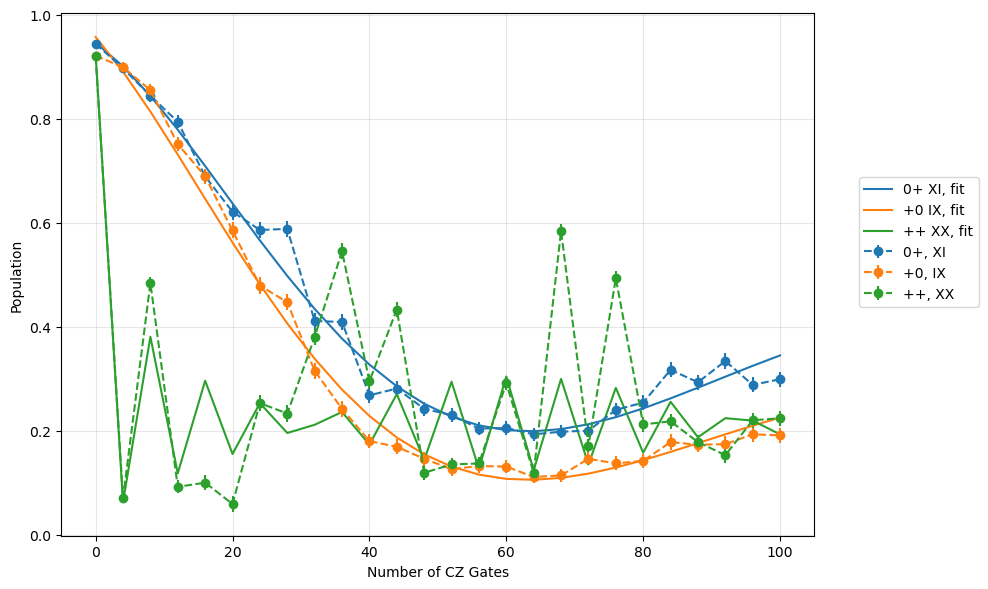

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Define colors for each group (e.g., 3 colors for 3 groups)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']

# Data curves
plt.errorbar(n_cz, pop_00[Exp.DD_0P_XI,:], sigma_00[Exp.DD_0P_XI,:], label='0+, XI', linestyle="--", marker='o', color=colors[0])
plt.errorbar(n_cz, pop_00[Exp.DD_P0_IX,:], sigma_00[Exp.DD_0P_XI,:], label='+0, IX', linestyle="--", marker='o', color=colors[1])
plt.errorbar(n_cz, pop_00[Exp.DD_PP_XX,:], sigma_00[Exp.DD_0P_XI,:], label='++, XX', linestyle="--", marker='o', color=colors[2])
# plt.plot(n_cz, pop_00[Exp.DD_0P_XX,:], label='0+, XX', linestyle="--", marker='o', color=colors[3])
# plt.plot(n_cz, pop_00[Exp.DD_P0_XX,:], label='+0, XX', linestyle="--", marker='o', color=colors[4])

# Fit curves (use the same color as the corresponding data curve)
t = np.linspace(0, n_cz[-1], num=int(n_cz[-1]/4)*1+1)
plt.plot(t, func_0P_XI(t, *func_params_0P_XI), label='0+ XI, fit', color=colors[0], marker='')
plt.plot(t, func_P0_IX(t, *func_params_P0_IX), label='+0 IX, fit', color=colors[1], marker='')
plt.plot(t, func_PP_XX(t, *func_params_PP_XX), label='++ XX, fit', color=colors[2], marker='')
# plt.plot(t, func_0P_XX(t, *func_params_0P_XX), label='0+ XX, fit', color=colors[3], marker='^')
# plt.plot(t, func_P0_XX(t, *func_params_P0_XX), label='+0 XX, fit', color=colors[4], marker='^')

plt.xlabel('Number of CZ Gates')
plt.ylabel('Population')

plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')
plt.tight_layout()
plt.show()